In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
import warnings
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import OneHotEncoder
from tensorflow.keras.layers import Input, Dense, LSTM,Conv2D,Conv1D,Flatten,MaxPooling2D,GlobalAveragePooling2D,Dropout,Bidirectional,Attention
from keras.models import Model
from keras.callbacks import EarlyStopping
from sklearn.metrics import confusion_matrix, accuracy_score
from sklearn.manifold import TSNE
import tensorflow as tf
import keras

In [2]:
pip install shap

Note: you may need to restart the kernel to use updated packages.


In [3]:
import shap
import numpy as np


In [4]:

# Display the version of each library
print("pandas version:", pd.__version__)
print("matplotlib version:", plt.matplotlib.__version__)
print("seaborn version:", sns.__version__)
print("numpy version:", np.__version__)
print("scikit-learn version:", StandardScaler().fit_transform([[0]])[0, 0])  # sklearn version
print("tensorflow version:", tf.__version__)  # assuming 'tf' is your TensorFlow import
print("keras version:", keras.__version__)

pandas version: 2.0.3
matplotlib version: 3.7.4
seaborn version: 0.12.2
numpy version: 1.24.3
scikit-learn version: 0.0
tensorflow version: 2.13.0
keras version: 2.13.1


In [5]:
warnings.filterwarnings(action="ignore")

In [6]:
df = pd.read_excel("/kaggle/input/algo-banknifty/Test Data Set  Requirements.xlsx",sheet_name="Data")

In [19]:
feature_data = df[df.strike == 1]
feature_data["spot_closing"] = df[df.strike == 0].close.to_list()
# feature_data["diff_closing_opening"] = feature_data.close.shift() - feature_data.open
feature_data["oi_change"] = np.log(feature_data.oi).pct_change()
feature_data["log_Target_price"] = np.log(feature_data.close)
feature_data["log_Target_return"] = feature_data.log_Target_price.pct_change()
feature_data["Target"] = feature_data["log_Target_return"].apply(lambda x: 0 if x > 0 else 1)
feature_data.fillna(0,inplace=True)
feature_data.drop(columns=["type","strike"],inplace=True)
feature_data.head()

,Unnamed: 0,date,open,high,low,close,volume,oi,spot_closing,oi_change,log_Target_price,log_Target_return,Target
375,0,2023-02-02 09:15:00,40289.00,40420.7,40217.95,40276.75,156150,2377775,40058.25,0.000000,10.603530,0.000000,1
376,1,2023-02-02 09:16:00,40251.15,40265.9,40074.40,40123.70,90750,2377775,39906.75,0.000000,10.599722,-0.000359,1
377,2,2023-02-02 09:17:00,40125.00,40126.1,40007.80,40061.30,68250,2409850,39812.45,0.000913,10.598166,-0.000147,1
378,3,2023-02-02 09:18:00,40040.60,40105.8,40016.95,40094.25,72675,2409850,39852.25,0.000000,10.598988,0.000078,0
379,4,2023-02-02 09:19:00,40079.75,40090.9,40024.65,40071.75,58550,2409850,39834.70,0.000000,10.598427,-0.000053,1


In [21]:
# adding option data and strike price as feature 
def option_value(data, refer, _type_, shift,which):
    ls = []
    df = refer
    if which == "price":
        which = "close"
    for i in data.date:
        element = df[(df.date == i) & (df["type"]==_type_) &
                (df["strike"] == int(data.loc[data[data.date == i].index,"strike_price"].values[0] + shift))][f"{which}"].values[0]
    
        ls.append(element)
    return ls

# adding ATM value and oi of CE and PE at corresponding time
feature_data["strike_price"] = round(feature_data["spot_closing"]/100)*100
feature_data["atm_ce_price"] = option_value(feature_data, df, "CE", shift=0,which="price") 
feature_data["atm_pe_price"] = option_value(feature_data, df, "PE", shift=0,which="price") 
feature_data["atm_ce_oi"] = option_value(feature_data, df, "CE", shift=0,which="oi") 
feature_data["atm_pe_oi"] = option_value(feature_data, df, "PE", shift=0,which="oi")

# adding three consecutive ITM value and oi of CE and PE at corresponding time
feature_data["1itm_ce_price"] = option_value(feature_data,df,"CE",shift=(-100),which="price")
feature_data["1itm_pe_price"] = option_value(feature_data,df,"PE",shift=(-100),which="price")
feature_data["1itm_ce_oi"] = option_value(feature_data,df,"CE",shift=(-100),which="oi")
feature_data["1itm_pe_oi"] = option_value(feature_data,df,"PE",shift=(-100),which="oi") 
feature_data["2itm_ce_price"] = option_value(feature_data,df,"CE",shift=(-200),which="price") 
feature_data["2itm_pe_price"] = option_value(feature_data,df,"PE",shift=(-200),which="price")
feature_data["2itm_ce_oi"] = option_value(feature_data,df,"CE",shift=(-200),which="oi") 
feature_data["2itm_pe_oi"] = option_value(feature_data,df,"PE",shift=(-200),which="oi") 
feature_data["3itm_ce_price"] = option_value(feature_data,df,"CE",shift=(-300),which="price") 
feature_data["3itm_pe_price"] = option_value(feature_data,df,"PE",shift=(-300),which="price")
feature_data["3itm_ce_oi"] = option_value(feature_data,df,"CE",shift=(-300),which="oi")
feature_data["3itm_pe_oi"] = option_value(feature_data,df,"PE",shift=(-300),which="oi") 

# adding three consecutive OTM value and oi of CE and PE at corresponding time
feature_data["1otm_ce_price"] = option_value(feature_data,df,"CE",shift=(100),which="price")
feature_data["1otm_pe_price"] = option_value(feature_data,df,"PE",shift=(100),which="price")
feature_data["1otm_ce_oi"] = option_value(feature_data,df,"CE",shift=(100),which="oi")
feature_data["1otm_pe_oi"] = option_value(feature_data,df,"PE",shift=(100),which="oi") 
feature_data["2otm_ce_price"] = option_value(feature_data,df,"CE",shift=(200),which="price") 
feature_data["2otm_pe_price"] = option_value(feature_data,df,"PE",shift=(200),which="price")
feature_data["2otm_ce_oi"] = option_value(feature_data,df,"CE",shift=(200),which="oi") 
feature_data["2otm_pe_oi"] = option_value(feature_data,df,"PE",shift=(200),which="oi") 
feature_data["3otm_ce_price"] = option_value(feature_data,df,"CE",shift=(300),which="price") 
feature_data["3otm_pe_price"] = option_value(feature_data,df,"PE",shift=(300),which="price")
feature_data["3otm_ce_oi"] = option_value(feature_data,df,"CE",shift=(300),which="oi")
feature_data["3otm_pe_oi"] = option_value(feature_data,df,"PE",shift=(300),which="oi") 

In [22]:
feature_data["consecutive_ce_oi"] = feature_data['atm_ce_oi'] + feature_data['1itm_ce_oi'] + feature_data['2itm_ce_oi'] + feature_data['3itm_ce_oi'] + feature_data['1otm_ce_oi'] +feature_data['1otm_ce_oi'] +feature_data['3otm_ce_oi'] 

feature_data["consecutive_pe_oi"] = feature_data['atm_pe_oi'] + feature_data['1itm_pe_oi'] + feature_data['2itm_pe_oi'] + feature_data['3itm_pe_oi'] + feature_data['1otm_pe_oi'] +feature_data['1otm_pe_oi'] +feature_data['3otm_pe_oi'] 


feature_data["ce_oi_change"] = np.log(feature_data["consecutive_ce_oi"]).pct_change()
feature_data["pe_oi_change"] = np.log(feature_data["consecutive_pe_oi"]).pct_change()

In [23]:
feature_data.columns

Index(['Unnamed: 0', 'date', 'open', 'high', 'low', 'close', 'volume', 'oi',
       'spot_closing', 'oi_change', 'log_Target_price', 'log_Target_return',
       'Target', 'strike_price', 'atm_ce_price', 'atm_pe_price', 'atm_ce_oi',
       'atm_pe_oi', '1itm_ce_price', '1itm_pe_price', '1itm_ce_oi',
       '1itm_pe_oi', '2itm_ce_price', '2itm_pe_price', '2itm_ce_oi',
       '2itm_pe_oi', '3itm_ce_price', '3itm_pe_price', '3itm_ce_oi',
       '3itm_pe_oi', '1otm_ce_price', '1otm_pe_price', '1otm_ce_oi',
       '1otm_pe_oi', '2otm_ce_price', '2otm_pe_price', '2otm_ce_oi',
       '2otm_pe_oi', '3otm_ce_price', '3otm_pe_price', '3otm_ce_oi',
       '3otm_pe_oi', 'consecutive_ce_oi', 'consecutive_pe_oi', 'ce_oi_change',
       'pe_oi_change'],
      dtype='object')

In [24]:
data = feature_data[["Target","date", 'open','atm_ce_price','volume', 'oi',
       'spot_closing', 'oi_change',
       'atm_pe_price', 'atm_ce_oi', 'atm_pe_oi', '1itm_ce_price',
       '1itm_pe_price', '1itm_ce_oi', '1itm_pe_oi', '2itm_ce_price',
       '2itm_pe_price', '2itm_ce_oi', '2itm_pe_oi', '3itm_ce_price',
       '3itm_pe_price', '3itm_ce_oi', '3itm_pe_oi', '1otm_ce_price',
       '1otm_pe_price', '1otm_ce_oi', '1otm_pe_oi', '2otm_ce_price',
       '2otm_pe_price', '2otm_ce_oi', '2otm_pe_oi', '3otm_ce_price',
       '3otm_pe_price', '3otm_ce_oi', '3otm_pe_oi', 'consecutive_ce_oi',
       'consecutive_pe_oi', 'ce_oi_change', 'pe_oi_change']]
data = data[data.date > "2023-02-02 09:20:00"]
print(data.shape)
data.head()


(369, 39)


,Target,date,open,atm_ce_price,volume,oi,spot_closing,oi_change,atm_pe_price,atm_ce_oi,...,2otm_ce_oi,2otm_pe_oi,3otm_ce_price,3otm_pe_price,3otm_ce_oi,3otm_pe_oi,consecutive_ce_oi,consecutive_pe_oi,ce_oi_change,pe_oi_change
381,1,2023-02-02 09:21:00,40091.70,303.30,53025,2475375,39838.2,0.0,274.65,542125,...,1369325,2023700,167.55,434.15,435175,416925,3027150,5633350,-0.031398,-0.016408
382,0,2023-02-02 09:22:00,40060.00,313.95,30050,2475375,39934.7,0.0,256.70,803425,...,435175,416925,172.35,416.95,529975,498200,4910425,7301000,0.032415,0.016682
383,0,2023-02-02 09:23:00,40172.40,272.55,44400,2475375,40055.5,0.0,282.00,435175,...,508700,294675,156.85,452.85,399175,365375,4609175,5559350,-0.004109,-0.017245
384,0,2023-02-02 09:24:00,40387.20,316.20,110075,2475375,40170.5,0.0,303.00,529975,...,399175,365375,172.40,464.10,1691150,997200,5846450,5321800,0.015497,-0.002812
385,0,2023-02-02 09:25:00,40436.45,326.70,45600,2475375,40221.3,0.0,294.60,529975,...,399175,365375,181.60,451.35,1691150,997200,5846450,5321800,0.000000,0.000000


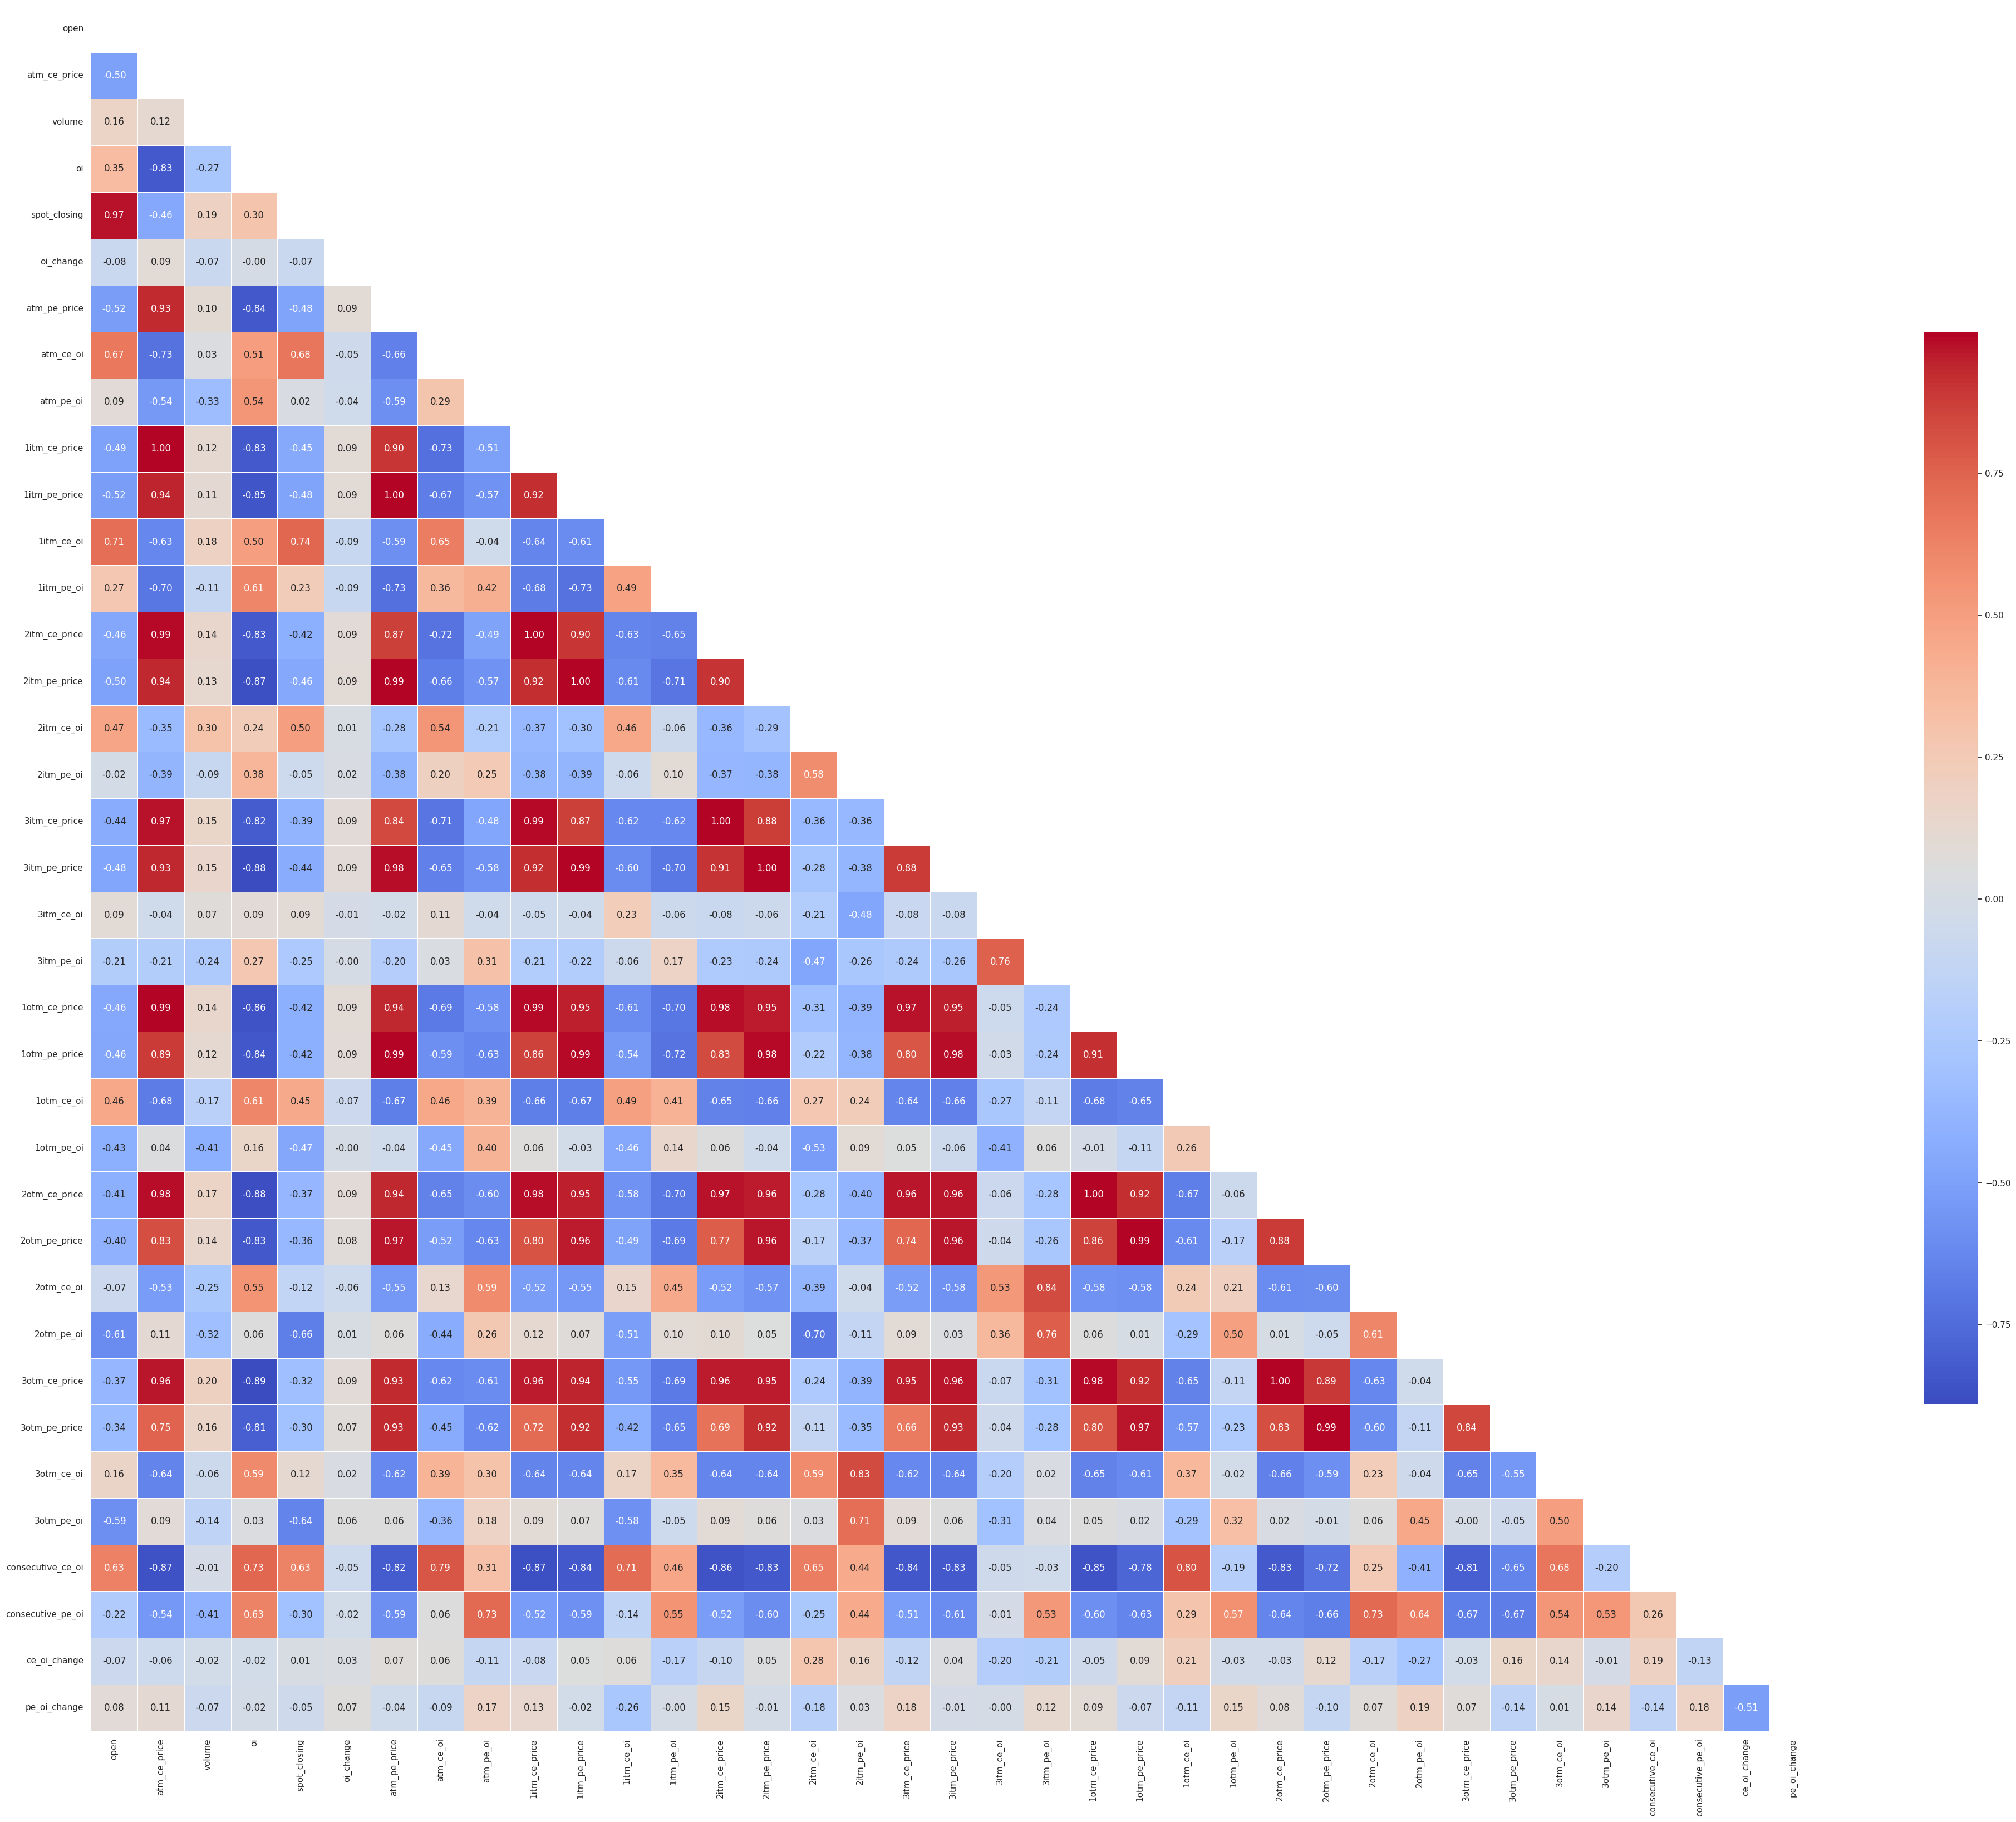

In [25]:
cor = data.drop(columns=["date","Target"])
corr = cor.corr()

# Create a heatmap with annotations
sns.set(style='white')
mask = np.triu(np.ones_like(corr, dtype=bool))
f, ax = plt.subplots(figsize=(50, 50))
sns.heatmap(corr, mask=mask, cmap='coolwarm', annot=True, fmt='.2f',
            square=True, linewidths=.5, cbar_kws={"shrink": .5})
plt.show()

In [26]:
corr_matrix = cor.corr()
upper_tri = corr_matrix.where(np.triu(np.ones(corr_matrix.shape),k=1).astype(bool))
to_drop = [column for column in upper_tri.columns if any(upper_tri[column] > 0.98)]
print("No. of Columns to drop",len(to_drop))
to_drop

No. of Columns to drop 12


['1itm_ce_price',
 '1itm_pe_price',
 '2itm_ce_price',
 '2itm_pe_price',
 '3itm_ce_price',
 '3itm_pe_price',
 '1otm_ce_price',
 '1otm_pe_price',
 '2otm_ce_price',
 '2otm_pe_price',
 '3otm_ce_price',
 '3otm_pe_price']

## model build

In [28]:
def SlidingWindow(df, w, s):
    X = []
    Y = []
    # Iterate through the rows of the DataFrame in steps of size s
    for i in range(0, len(df)-w, s):
        # Extract a window of width w from the DataFrame, starting at row i
        x = np.array(df.iloc[i:i+w, 1:])
        # Extract the target value for the last row of the window
        y = np.array(df.iloc[i+w-1, 0])
        # Append the window and target value to the X and Y lists, respectively
        X.append(x)
        Y.append(y)

    # Convert the X and Y lists to numpy arrays
    X = np.array(X)
    Y = np.array(Y)

    return X, Y

In [29]:
X, Y = SlidingWindow(data.drop(columns="date"), 10, 1)
print(X.shape)
print(Y.shape)

(359, 10, 37)
(359,)


In [30]:
sc = StandardScaler()
sc.fit(data.drop(columns=["Target","date"]))

X_sc = sc.transform(X.reshape(-1, X.shape[-1])).reshape(X.shape)

# Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
enc = OneHotEncoder(sparse=False)

# Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
enc.fit(Y.reshape(-1, 1))

# Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
Y_enc = enc.transform(Y.reshape(-1, 1))

In [31]:
cutoff = 320
x_train = X_sc[:cutoff]
y_train = Y_enc[:cutoff]
x_test = X_sc[cutoff:]
y_test = Y_enc[cutoff:]

In [32]:
def NN_model(x_train, y_train):
    # Define input layer with the correct input shape
    inputs = Input(shape=(x_train.shape[1]))

    # Define hidden layers with 100 nodes and selu activation function
    hidden_layer = Dense(100, activation='selu')(inputs)
    hidden_layer = Dense(100, activation='selu')(hidden_layer)

    # Define output layer with softmax activation function
    outputs = Dense(y_train.shape[1], activation='softmax')(hidden_layer)

    # Define the model
    model = Model(inputs=inputs, outputs=outputs)

    # Compile the model with categorical cross-entropy loss function and Adam optimizer
    model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    # Print the summary of the model
    print(model.summary())
    return model


In [33]:

def LSTM_model(X_train,y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1],X_train.shape[2]))

    # Define encoder layers
    encoded = Bidirectional(LSTM(128,activation="tanh",return_sequences=True))(input_layer)
    encoded = LSTM(128, activation="tanh")(encoded)
    
    # Define decoder layers
    decoded = Dense(300, activation='relu')(encoded)
    decoded = Dropout(0.5)(decoded)
    decoded = Dense(y_train.shape[1], activation='sigmoid')(decoded)

    # Define LSTM model
    lstm_model = Model(inputs=input_layer, outputs=decoded)
    # Compile LSTM  model
    lstm_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    print(lstm_model.summary())
    return lstm_model

In [34]:
def Simple_LSTM_model(X_train, y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # Single LSTM layer
    lstm_layer = LSTM(128, activation="tanh")(input_layer)

    # Dense layer for classification
    output_layer = Dense(y_train.shape[1], activation='sigmoid')(lstm_layer)  # 'sigmoid' for binary classification

    # Define LSTM model
    lstm_model = Model(inputs=input_layer, outputs=output_layer)

    # Compile LSTM model
    lstm_model.compile(loss='binary_crossentropy',  # 'binary_crossentropy' for binary classification
                       optimizer='adam',
                       metrics=['accuracy'])

    return lstm_model

In [35]:
def CNN_model(X_train, y_train):
    # Define input layer
    input_layer = Input(shape=(X_train.shape[1], X_train.shape[2]))

    # Define encoder layers
    encoded = Conv1D(filters=32, kernel_size=3, activation='relu')(input_layer)
    encoded = Conv1D(filters=32, kernel_size=3, activation='relu') (encoded)

    encoded = Flatten()(encoded)

    decoded = Dense(units=128, activation='relu')(encoded)
    decoded = Dropout(rate=0.5)(decoded)

    decoded = Dense(units=y_train.shape[1], activation='softmax')(decoded)

    # Define autoencoder model
    cnn_model = Model(inputs=input_layer, outputs=decoded)

    # Compile autoencoder model with additional regularization
    cnn_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

    return cnn_model

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 37)]          0         
                                                                 
 bidirectional (Bidirection  (None, 10, 256)           169984    
 al)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 300)               38700     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 602       
                                                             

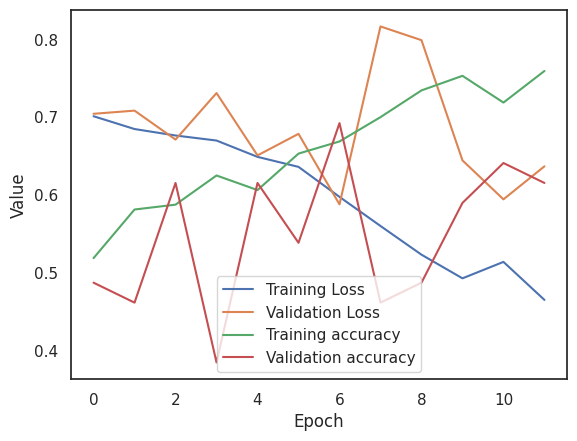

In [36]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model1 = LSTM_model(x_train,y_train)
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model1.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

Epoch 1/200
10/10 [==============================] - 3s 77ms/step - loss: 0.7170 - accuracy: 0.5156 - val_loss: 0.6872 - val_accuracy: 0.5897
Epoch 2/200
10/10 [==============================] - 0s 16ms/step - loss: 0.6768 - accuracy: 0.5375 - val_loss: 0.6748 - val_accuracy: 0.6154
Epoch 3/200
10/10 [==============================] - 0s 16ms/step - loss: 0.6562 - accuracy: 0.6344 - val_loss: 0.6804 - val_accuracy: 0.6410
Epoch 4/200
10/10 [==============================] - 0s 16ms/step - loss: 0.6428 - accuracy: 0.6375 - val_loss: 0.6785 - val_accuracy: 0.5641
Epoch 5/200
10/10 [==============================] - 0s 15ms/step - loss: 0.6306 - accuracy: 0.6656 - val_loss: 0.6625 - val_accuracy: 0.7436
Epoch 6/200
10/10 [==============================] - 0s 17ms/step - loss: 0.6182 - accuracy: 0.6656 - val_loss: 0.6557 - val_accuracy: 0.6667
Epoch 7/200
10/10 [==============================] - 0s 17ms/step - loss: 0.6070 - accuracy: 0.6875 - val_loss: 0.6453 - val_accuracy: 0.6410
Epoch 

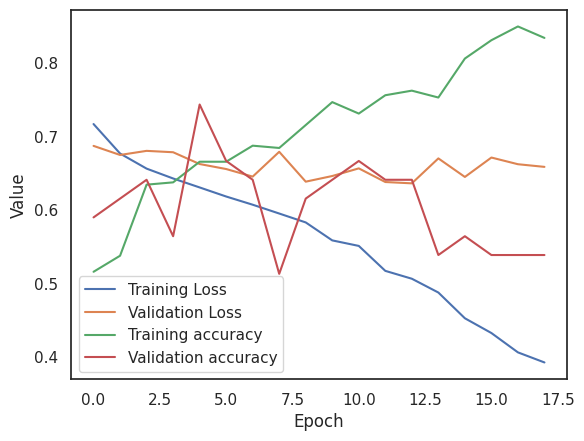

In [37]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model3 = Simple_LSTM_model(x_train,y_train)
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model3.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

Epoch 1/200
10/10 [==============================] - 1s 31ms/step - loss: 0.8264 - accuracy: 0.5437 - val_loss: 0.9217 - val_accuracy: 0.3590
Epoch 2/200
10/10 [==============================] - 0s 8ms/step - loss: 0.7662 - accuracy: 0.5750 - val_loss: 0.6812 - val_accuracy: 0.5897
Epoch 3/200
10/10 [==============================] - 0s 6ms/step - loss: 0.7012 - accuracy: 0.5406 - val_loss: 0.6848 - val_accuracy: 0.6154
Epoch 4/200
10/10 [==============================] - 0s 6ms/step - loss: 0.6985 - accuracy: 0.5469 - val_loss: 0.6935 - val_accuracy: 0.5385
Epoch 5/200
10/10 [==============================] - 0s 6ms/step - loss: 0.6593 - accuracy: 0.6469 - val_loss: 0.7650 - val_accuracy: 0.3590
Epoch 6/200
10/10 [==============================] - 0s 7ms/step - loss: 0.6307 - accuracy: 0.6375 - val_loss: 0.7292 - val_accuracy: 0.5128
Epoch 7/200
10/10 [==============================] - 0s 6ms/step - loss: 0.6020 - accuracy: 0.6656 - val_loss: 0.7448 - val_accuracy: 0.4872


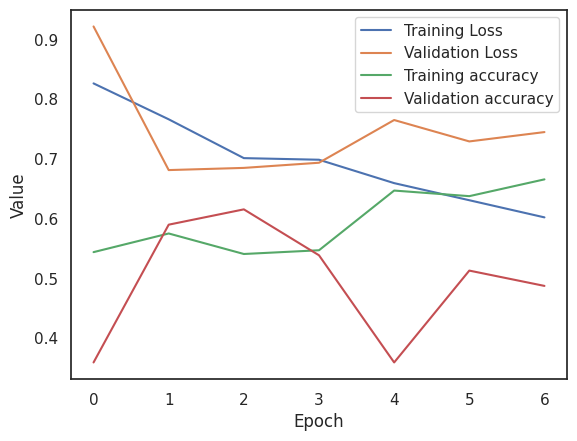

In [38]:
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Create model
model2 = CNN_model(x_train,y_train)
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model2.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

In [ ]:
# for NN
# X = data.drop(columns=["date","Target"])
# Y = np.array(data["Target"])

# sc = StandardScaler()
# sc.fit(data.drop(columns=["Target","date"]))
# X_sc = sc.transform(X)

# # Create an instance of the OneHotEncoder with the 'sparse' parameter set to False
# enc = OneHotEncoder(sparse=False)

# # Fit the OneHotEncoder to the target values Y, which must be reshaped to have a single column
# enc.fit(Y.reshape(-1, 1))

# # Transform the target values Y to one-hot encoded form, by applying the OneHotEncoder to the reshaped Y array
# Y_enc = enc.transform(Y.reshape(-1, 1))

In [ ]:
print(X_sc.shape)

In [ ]:
cutoff = 250
x_train = X_sc[:cutoff]
y_train = Y_enc[:cutoff]
x_test = X_sc[cutoff:]
y_test = Y_enc[cutoff:]

In [ ]:

early_stop = EarlyStopping(monitor='val_loss', patience=15)
# Create model
model4 = NN_model(x_train,y_train)
# Train the model with 20 epochs and batch size of 32, using the early stopping callback
history = model4.fit(x_train, y_train, epochs=200, batch_size=32, validation_data=(x_test, y_test), callbacks=[early_stop])

# Plot the training history for loss and accuracy
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.plot(history.history['accuracy'], label='Training accuracy')
plt.plot(history.history['val_accuracy'], label='Validation accuracy')
plt.xlabel('Epoch')
plt.ylabel('Value')
plt.legend()
plt.show()

# Evaluation of LSTM model


In [39]:
y_pred = model1.predict(x_test, verbose=0)
y_pred = np.where(y_pred>0.4,0,1)
for i in range(10):
    print(y_pred[i],y_test[i])

[0 1] [1. 0.]
[0 0] [1. 0.]
[0 0] [0. 1.]
[1 0] [1. 0.]
[1 0] [1. 0.]
[1 0] [0. 1.]
[1 0] [0. 1.]
[1 0] [1. 0.]
[0 1] [0. 1.]
[0 1] [0. 1.]


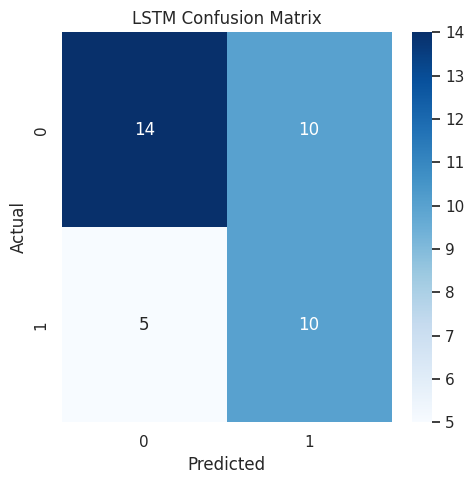

LSTM accuracy score: 0.6153846153846154


In [40]:
def plot_confusion_matrix(y_true, y_pred, title):
    f, ax = plt.subplots(figsize=(5, 5))
    cm = confusion_matrix(y_true, y_pred)
    sns.heatmap(cm, annot=True, cmap='Blues',ax=ax)
    ax.set_title(title)
    ax.set_xlabel('Predicted')
    ax.set_ylabel('Actual')
    plt.tight_layout()
    plt.show()

y_pred = enc.inverse_transform(model1.predict(x_test, verbose=0))
y_true = enc.inverse_transform(y_test)
    
# Plot the confusion matrix and print the f1 score for each algorithm
plot_confusion_matrix(y_true, y_pred, 'LSTM Confusion Matrix')
print("LSTM accuracy score:", accuracy_score(y_true, y_pred))

### classification report

In [41]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_true, y_pred))
print(f"AUC:{roc_auc_score(y_true, y_pred)}")

              precision    recall  f1-score   support

           0       0.74      0.58      0.65        24
           1       0.50      0.67      0.57        15

    accuracy                           0.62        39
   macro avg       0.62      0.62      0.61        39
weighted avg       0.65      0.62      0.62        39

AUC:0.6249999999999999


### Featrure Importance

<Axes: >

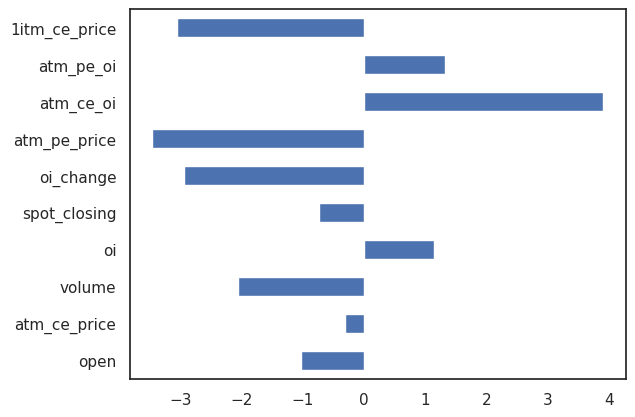

In [42]:
weights = model1.get_weights()
w = pd.DataFrame(weights[0],index=data.drop(columns=["Target","date"]).columns.to_list())
w['sum_all_columns'] = w.sum(axis=1)
w.head(10)["sum_all_columns"].plot(kind="barh")

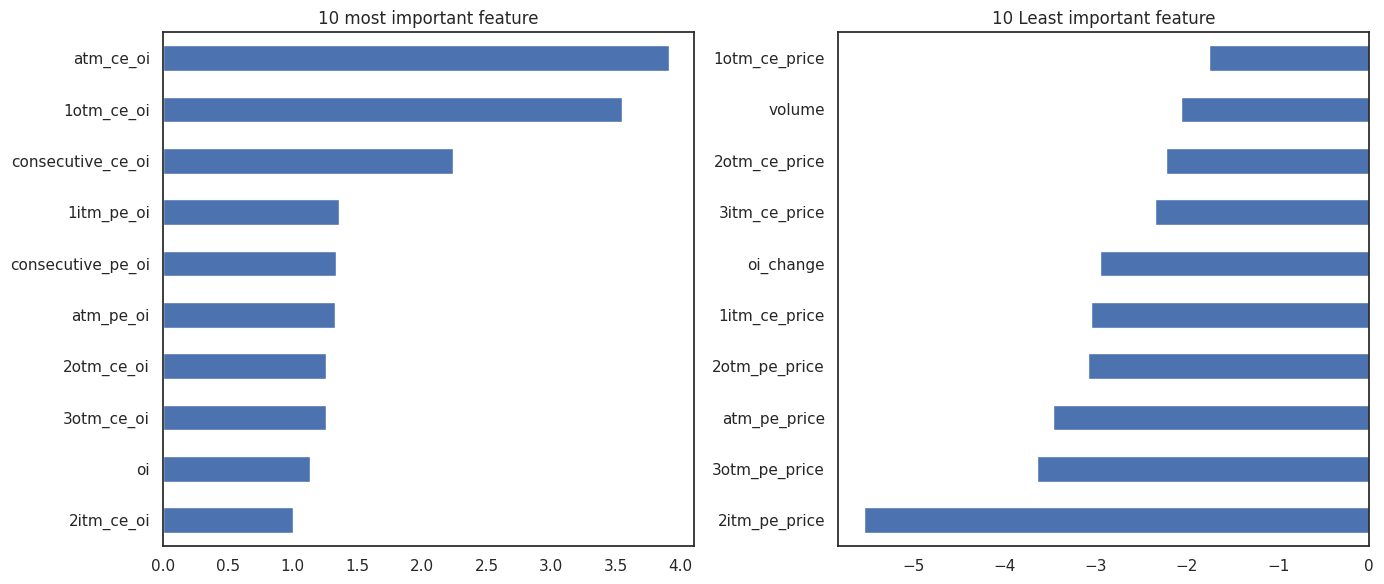

In [43]:
w_sorted = w.sort_values(by="sum_all_columns")

# Create subplots
fig, ax = plt.subplots(figsize=(14, 6), ncols=2)

# Plot the top 10
w_sorted.tail(10)["sum_all_columns"].plot(kind="barh", ax=ax[0])
ax[0].set_title('10 most important feature')

# Plot the bottom 10
w_sorted.head(10)["sum_all_columns"].plot(kind="barh", ax=ax[1])
ax[1].set_title('10 Least important feature')

plt.tight_layout()
plt.show()

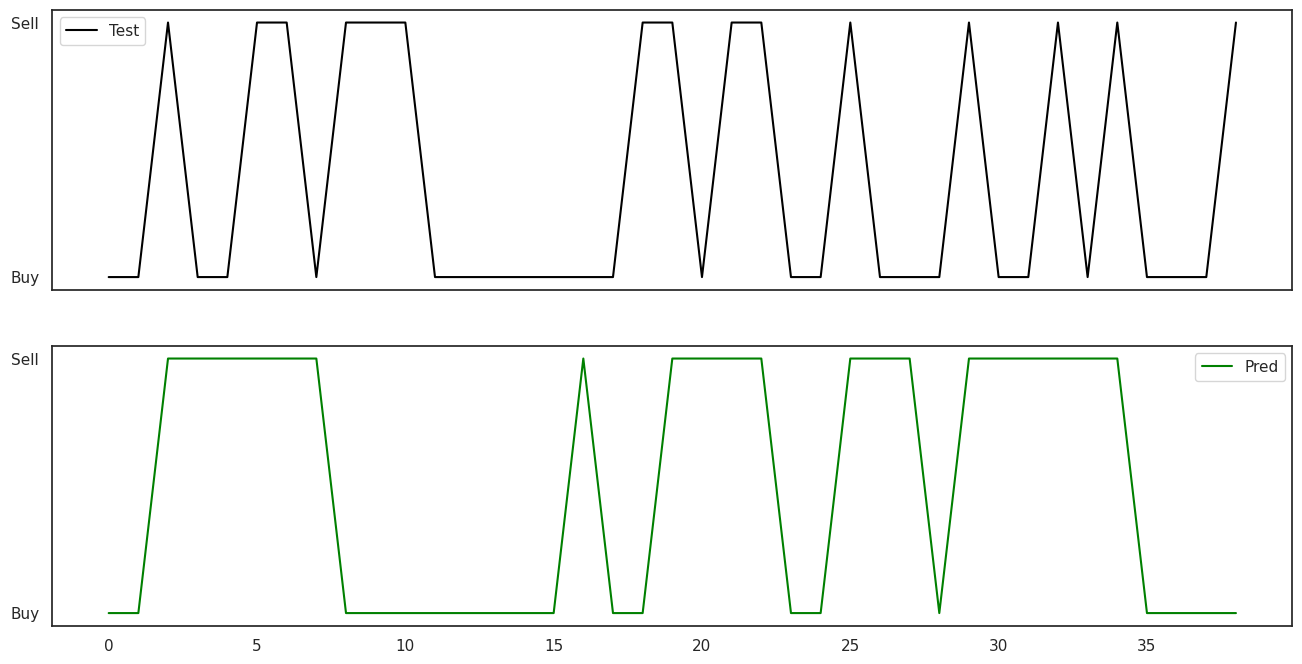

In [44]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

y_ticks = [0, 1]
y_labels = ['Buy', 'Sell']

# Plot the first subplot (top)
axs[0].plot(y_true, color='black', label='Test')
axs[0].set_yticks(y_ticks)
axs[0].set_yticklabels(y_labels)
axs[0].legend()

# Plot the second subplot (bottom)
axs[1].plot(y_pred, color='green', label='Pred')
axs[1].set_yticks(y_ticks)
axs[1].set_yticklabels(y_labels)
axs[1].legend()

# Show the plots
plt.show()

# Simple UNidiretional LSTM

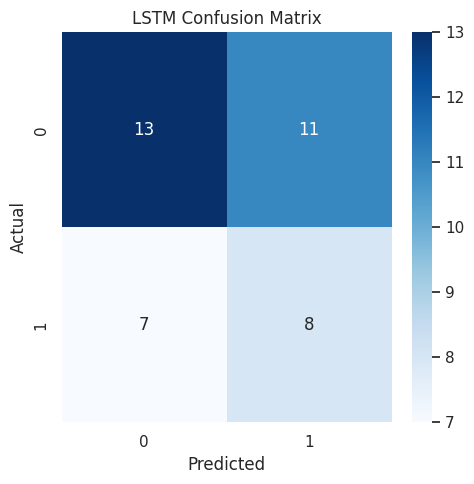

LSTM accuracy score: 0.5384615384615384


In [45]:
y_pred = enc.inverse_transform(model3.predict(x_test, verbose=0))
y_true = enc.inverse_transform(y_test)
    
# Plot the confusion matrix and print the f1 score for each algorithm
plot_confusion_matrix(y_true, y_pred, 'LSTM Confusion Matrix')
print("LSTM accuracy score:", accuracy_score(y_true, y_pred))

In [46]:
from sklearn.metrics import classification_report, roc_auc_score
print(classification_report(y_true, y_pred))
print(f"AUC:{roc_auc_score(y_true, y_pred)}")

              precision    recall  f1-score   support

           0       0.65      0.54      0.59        24
           1       0.42      0.53      0.47        15

    accuracy                           0.54        39
   macro avg       0.54      0.54      0.53        39
weighted avg       0.56      0.54      0.54        39

AUC:0.5375


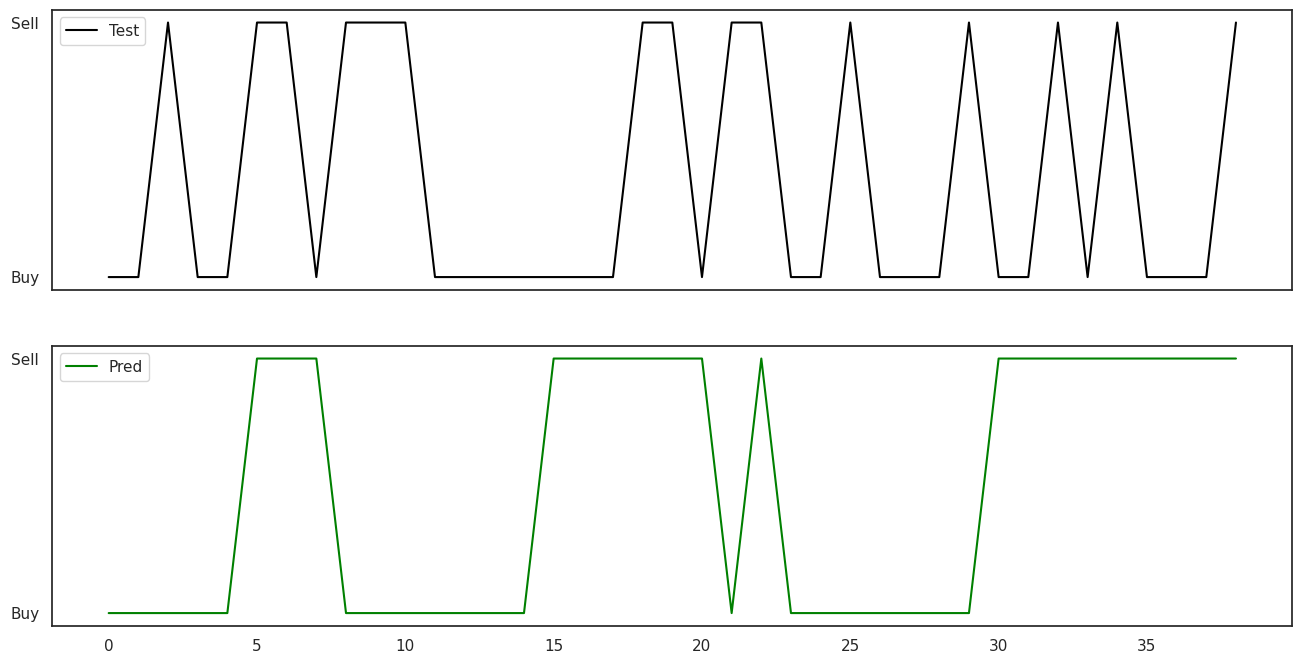

In [47]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

y_ticks = [0, 1]
y_labels = ['Buy', 'Sell']

# Plot the first subplot (top)
axs[0].plot(y_true, color='black', label='Test')
axs[0].set_yticks(y_ticks)
axs[0].set_yticklabels(y_labels)
axs[0].legend()

# Plot the second subplot (bottom)
axs[1].plot(y_pred, color='green', label='Pred')
axs[1].set_yticks(y_ticks)
axs[1].set_yticklabels(y_labels)
axs[1].legend()

# Show the plots
plt.show()

# CNN

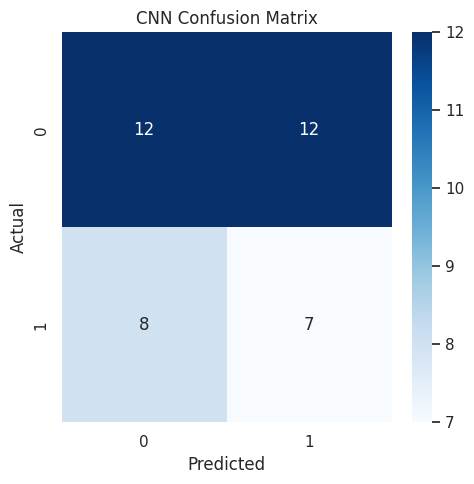

CNN accuracy score: 0.48717948717948717


In [48]:
y_pred = enc.inverse_transform(model2.predict(x_test, verbose=0))
y_true = enc.inverse_transform(y_test)
    
# Plot the confusion matrix and print the f1 score for each algorithm
plot_confusion_matrix(y_true, y_pred, 'CNN Confusion Matrix')
print("CNN accuracy score:", accuracy_score(y_true, y_pred))

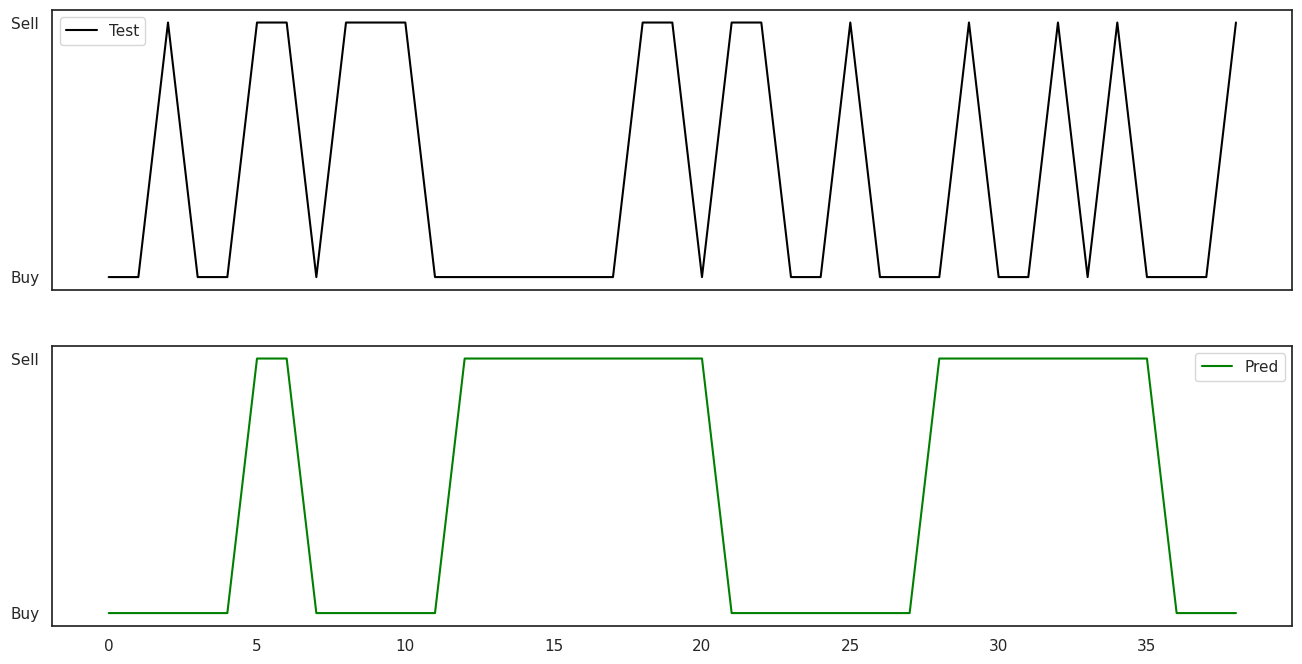

In [49]:
fig, axs = plt.subplots(2, 1, figsize=(16, 8), sharex=True)

y_ticks = [0, 1]
y_labels = ['Buy', 'Sell']

# Plot the first subplot (top)
axs[0].plot(y_true, color='black', label='Test')
axs[0].set_yticks(y_ticks)
axs[0].set_yticklabels(y_labels)
axs[0].legend()

# Plot the second subplot (bottom)
axs[1].plot(y_pred, color='green', label='Pred')
axs[1].set_yticks(y_ticks)
axs[1].set_yticklabels(y_labels)
axs[1].legend()

# Show the plots
plt.show()

# BackTest

In [61]:
def backtest(y_pred, lot_size, nn=False):
    predicted =pd.DataFrame(y_pred,columns=["predicted"])
    if nn:
        cutoff = 250
    else:
        cutoff = 330
    predicted["date"] = data.date[cutoff:].to_list()
    predicted["Action"]=predicted["predicted"].apply(lambda x: "Sell" if x==1 else "Buy")
    predicted["price"] = sta[sta.date > "2023-02-02 09:20:00"].close[cutoff:].to_list()
    predicted["lot amount"] = predicted["price"] * 2.5 * lot_size
    predicted["new_pred"] = predicted["predicted"].apply(lambda x:(-1) if x == 0 else 1)
    predicted["diff"] = predicted["new_pred"] - predicted["new_pred"].shift(1)
    predicted.fillna(0,inplace=True)
    predicted["predicted1"] = predicted.apply(lambda row: 2 if row["diff"] != 0 else row["predicted"], axis=1)
    predicted.at[len(predicted)-1,"predicted1"] = 2
    t1 = predicted[predicted.predicted1 != 2][["date","Action","price","lot amount"]]
    t1.columns = ["Entry Time","Trade",'Entry Price',"Entry Amount"]
    t1["closed_position"] = "Yes"
    t2 = predicted[predicted.predicted1 == 2][["date","price","lot amount"]]
    t2.columns = ["Exit Time", "Exit Price","Exit Amount"]
    exit_time = []
    count = 0
    for i_1, d_1 in t2.iterrows():
        d1 = d_1["Exit Time"]
        for i_2,d_2 in t1[count:].iterrows():
            if d1 > d_2["Entry Time"]:
                exit_time.append(d1)
                count += 1
            else:
                break

    t1["Exit Time"] = exit_time
    backtest = pd.merge(t1,t2,'inner')
    backtest["profit/loss"] = np.where(backtest["Trade"] == "Buy",
                                       -1 * (backtest["Entry Amount"] - backtest["Exit Amount"]),
                                       backtest["Entry Amount"] - backtest["Exit Amount"])
    print(f"Total profit from this statergy is {backtest['profit/loss'].cumsum()[len(backtest)-1] - len(backtest) * 30}.")
    return backtest

In [62]:
CNN_y_pred = enc.inverse_transform(model2.predict(x_test, verbose=0))
CNN_backtest = backtest(CNN_y_pred, 1)

Total profit from this statergy is 1244.0.


In [63]:
LSTM_y_pred = enc.inverse_transform(model1.predict(x_test, verbose=0))
LSTM_backtest = backtest(LSTM_y_pred, 1)

Total profit from this statergy is 1826.625.


In [64]:
LSTM_backtest

,Entry Time,Trade,Entry Price,Entry Amount,closed_position,Exit Time,Exit Price,Exit Amount,profit/loss
0,2023-02-02 14:51:00,Buy,40955.00,102387.500,Yes,2023-02-02 14:53:00,40963.05,102407.625,20.125
1,2023-02-02 14:52:00,Buy,40951.80,102379.500,Yes,2023-02-02 14:53:00,40963.05,102407.625,28.125
2,2023-02-02 14:54:00,Sell,40995.55,102488.875,Yes,2023-02-02 14:59:00,40877.95,102194.875,294.000
3,2023-02-02 14:55:00,Sell,40930.70,102326.750,Yes,2023-02-02 14:59:00,40877.95,102194.875,131.875
4,2023-02-02 14:56:00,Sell,40911.30,102278.250,Yes,2023-02-02 14:59:00,40877.95,102194.875,83.375
5,2023-02-02 14:57:00,Sell,40920.00,102300.000,Yes,2023-02-02 14:59:00,40877.95,102194.875,105.125
6,2023-02-02 14:58:00,Sell,40890.50,102226.250,Yes,2023-02-02 14:59:00,40877.95,102194.875,31.375
7,2023-02-02 15:00:00,Buy,40827.25,102068.125,Yes,2023-02-02 15:07:00,41016.30,102540.750,472.625
8,2023-02-02 15:01:00,Buy,40852.15,102130.375,Yes,2023-02-02 15:07:00,41016.30,102540.750,410.375
9,2023-02-02 15:02:00,Buy,40892.95,102232.375,Yes,2023-02-02 15:07:00,41016.30,102540.750,308.375


In [60]:
LSTM_backtest.to_csv("LSTM_backtest.csv")

In [65]:
LSTM_backtest[LSTM_backtest.Trade == "Buy"]['profit/loss'].cumsum()

0       20.125
1       48.250
7      520.875
8      931.250
9     1239.625
10    1487.250
11    1699.500
12    1884.375
13    2043.375
14    2091.500
18    2139.625
26    2122.625
27    2118.125
Name: profit/loss, dtype: float64

In [71]:
LSTM_y_pred = enc.inverse_transform(model3.predict(x_test, verbose=0))
LSTM_backtest = backtest(LSTM_y_pred, 1)

Total profit from this statergy is 1452.375.


# Shap Explainer
## model1

In [67]:
x_test[1].flatten().shape

(370,)

In [68]:
model1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 10, 37)]          0         
                                                                 
 bidirectional (Bidirection  (None, 10, 256)           169984    
 al)                                                             
                                                                 
 lstm_1 (LSTM)               (None, 128)               197120    
                                                                 
 dense (Dense)               (None, 300)               38700     
                                                                 
 dropout (Dropout)           (None, 300)               0         
                                                                 
 dense_1 (Dense)             (None, 2)                 602       
                                                             

## model2

In [70]:
model1.save("model_LSTM.pkl")
model2.save("model_CNN.pkl")